## Atomic systems (Netket)
Figuring out how to represent and optimize for ground states of atomic systems

In [1]:
# Can start with simple ansatz, just get the Hamiltonian right, and the fermion - boson stuff
import netket as nk
import netket.experimental as nkx
import jax.numpy as jnp

RuntimeError: cannot load MPI library
Could not find module 'C:\Users\Parv\AppData\Roaming\Python\DLLs' (or one of its dependencies). Try using the full path with constructor syntax.
Could not find module 'C:\Users\Parv\AppData\Roaming\Python\Library\bin' (or one of its dependencies). Try using the full path with constructor syntax.
Could not find module 'c:\Users\Parv\anaconda3\envs\jax_cuda\DLLs\impi.dll' (or one of its dependencies). Try using the full path with constructor syntax.
Could not find module 'c:\Users\Parv\anaconda3\envs\jax_cuda\DLLs\msmpi.dll' (or one of its dependencies). Try using the full path with constructor syntax.
Could not find module 'c:\Users\Parv\anaconda3\envs\jax_cuda\Library\bin\impi.dll' (or one of its dependencies). Try using the full path with constructor syntax.
Could not find module 'c:\Users\Parv\anaconda3\envs\jax_cuda\Library\bin\msmpi.dll' (or one of its dependencies). Try using the full path with constructor syntax.
Could not find module 'impi.dll' (or one of its dependencies). Try using the full path with constructor syntax.
Could not find module 'msmpi.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [ ]:
nk.experimental.Part

In [7]:
# Hydrogen - 1 electron in atomic units
N = 1
geo = nkx.geometry.FreeSpace(d=3)
hi = nkx.hilbert.Particle(N=N, geometry=geo)

In [8]:
ekin = nk.operator.KineticEnergy(hi, mass=1.0)

def v(x):
    # electron nuclear, electron electron, nuclear nuclear
    return - 1/(jnp.linalg.norm(x))  # Centred at (0,0)

pot = nk.operator.PotentialEnergy(hi, v)

ha = ekin + pot

In [9]:
# Define Ansatz with two parameters - controlling Gaussian and the scaling

import flax.linen as nn
from flax import nnx
import jax
from flax.linen.dtypes import promote_dtype
from flax.linen.initializers import normal

from netket.utils.types import DType, Array, NNInitFunc

DType = jnp.float64


class Jastrow(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):
        self.j1 = nnx.Param(0.1 * jax.random.normal(rngs.params(), (1,)), dtype=complex)
        self.j2 = nnx.Param(0.1 * jax.random.normal(rngs.params(), (1,)), dtype=complex)

    def __call__(self, x: jax.Array):
        # NN correlation
        norm_x = jnp.linalg.norm(x, axis=1)
        return jnp.exp(- self.j1 * norm_x) * self.j2 * norm_x

In [10]:
### Neural Network Quantum State

class FFN(nnx.Module):
    def __init__(self, N: int, alpha:int = 10, *, rngs: nnx.Rngs):
        self.alpha = alpha
        self.linear = nnx.Linear(in_features=N, out_features = alpha * N, rngs=rngs,
                                  param_dtype=complex)

    def __call__(self, x: jax.Array):
        norm_x = jnp.linalg.norm(x, axis=1)
        y = self.linear(norm_x.reshape(norm_x.shape[0], 1))
        y = nnx.relu(y) # max(0, X)
        return jnp.sum(y, axis=-1)

In [11]:
jas_model = Jastrow(rngs=nnx.Rngs(0))

In [12]:
ffn_model = FFN(N=1, rngs=nnx.Rngs(0))
sa = nk.sampler.MetropolisGaussian(hi, sigma=0.01, n_chains=16, sweep_size=32)
vstate = nk.vqs.MCState(sa, ffn_model, n_samples=512)

In [13]:
vstate.init_parameters()
optimizer = nk.optimizer.Adam(
    learning_rate=0.01)

gs = nk.driver.VMC(
    ha, optimizer, variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.01),)


log = nk.logging.RuntimeLog()


In [14]:
# Burn in
for i in range(20):
    vstate.sample()

In [15]:
vstate.expect(ha)

-0.621+0.006j ± 0.042 [σ²=8.8e-01, R̂=1.375]

Either their sampling is wrong, or they're doing something really smart. There's no burn in, no adjusted step. They don't seem to track the Xs correctly. Something to discuss with the group.
The CQSL group implemented a Metropolis Gauss Adaptive - harmonic_interaction.py - https://github.com/cqsl/electron-tvmc/blob/main/harmonic_interaction.py. They probably have their own way of doing burn-in. These guys are not geniuses at continuous systems.

In [16]:
log = gs.run(n_iter=1000, out=log)

  0%|                                                                                                         …

/mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/optimizer/qgt/qgt_onthefly.py:139: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/e

AmbiguousLookupError: `is_scalar(JitTracer(~float64[]))` is ambiguous.

Candidates:
   is_scalar(x: [1mtyping.Union[numpy.ndarray, jax.Array][0m)                                                            
       <function is_scalar at 0x7a3a94217ec0> @                                                                    
   ]8;id=463232;file:///mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/numbers.py#69\[37m/mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/[0m]8;;\]8;id=738188;file:///mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/numbers.py#69\[1;4;37mnumbers.py[0m]8;;\]8;id=463232;file:///mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/numbers.py#69\[37m:69[0m]8;;\       
   is_scalar(x: [38;5;248mjax._src.core.[0m[1;38;5;248mTracer[0m)                                                                              
       <function is_scalar at 0x7a3a94217f60> @                                                                    
   ]8;id=950518;file:///mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/numbers.py#74\[37m/mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/[0m]8;;\]8;id=15989;file:///mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/numbers.py#74\[1;4;37mnumbers.py[0m]8;;\]8;id=950518;file:///mnt/c/Users/Parv/Doc/RA/Projects/QVMC/netket/env/lib/python3.12/site-packages/netket/utils/numbers.py#74\[37m:74[0m]8;;\       


c:\Users\Parv\anaconda3\envs\jax_cuda\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Parv\anaconda3\envs\jax_cuda\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Parv\anaconda3\envs\jax_cuda\lib\site-packages\numpy\ma\core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


Text(0.5, 1.0, 'Jastrow Ansatz')

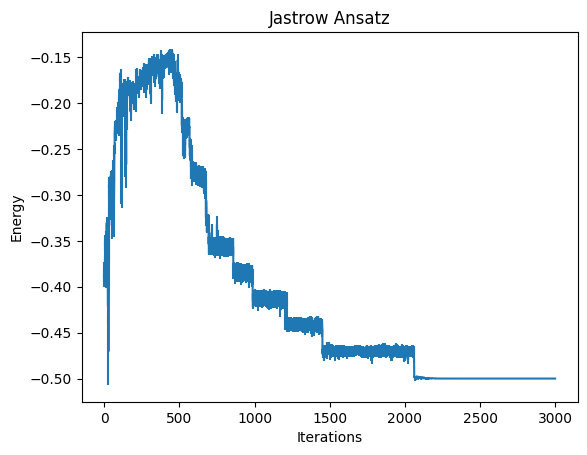

In [154]:
import matplotlib.pyplot as plt
data_jastrow = log[0]
plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
)


plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Jastrow Ansatz")

In [159]:
# just have a ham_t that takes t as an additional parameter and creates that td E field. Let's see what happens here directly
def Esin(x, t=0, w=0.5, Eo=0.02):
    return Eo * jnp.sin(w * t) * jnp.dot(jnp.array([0, 0, 1.0]), x)

In [160]:
Es = [Esin(jnp.array([1.0, 1.0, 1.0]), t=0.01 * T) for T in range(0,10000)]

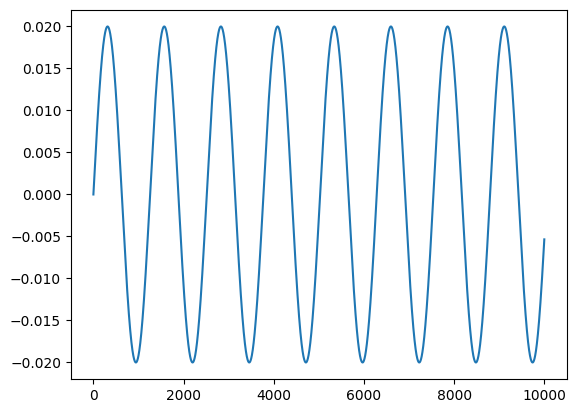

In [161]:
plt.plot(Es)

In [102]:
vstate.sampler_state

MetropolisSamplerState(# accepted = 18817/18944 (99.32960304054053%), rng state=[2441321543 3544068830])

In [162]:
def get_z_dipole(vstate):
    return jnp.mean(jnp.mean(vstate.samples, axis=0), axis=0)[2]

In [163]:
dipole = nk.operator.position

AttributeError: module 'netket.operator' has no attribute 'position'

In [168]:
# Save old params so I don't need to retrain every time

In [ ]:
### Time evolution loop

from tqdm import tqdm

energy_history = []
z_dips = []
E_field = []
n_steps = 10000
lr = 0.01
qgt = nk.optimizer.qgt.QGTJacobianDense(holomorphic=True)
sr = nk.optimizer.SR(diag_shift=1e-6, qgt=qgt)

Eo = 2.0
w = 0.5
dt = 0.005
burn_in_per_timestep = 10

for t in tqdm(range(n_steps)):

    for _ in range(burn_in_per_timestep):
        vstate.sample()
    
    ha_t = lambda t: ha + nk.operator.PotentialEnergy(
        hi, lambda x: Eo * jnp.sin(w * t * dt) * jnp.dot(jnp.array([0, 0, 1.0]), x))
    E, E_grad = vstate.expect_and_forces(ha)
    energy_history.append(E.mean.real)
    z_dips.append(get_z_dipole(vstate))
    E_field.append(jnp.mean(Eo * jnp.sin(w * t * dt)))

    theta_dot_flat = sr(vstate, E_grad)

    new_pars = jax.tree_util.tree_map(
        lambda x, y: x - lr * y, vstate.parameters, theta_dot_flat
    )

    vstate.parameters = new_pars

  3%|▎         | 310/10000 [00:18<09:30, 16.99it/s]


KeyboardInterrupt: 

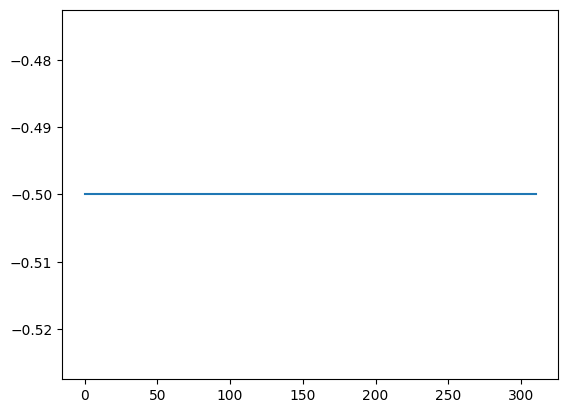

In [200]:
plt.plot(energy_history)

In [201]:
t = jnp.array(z_dips)

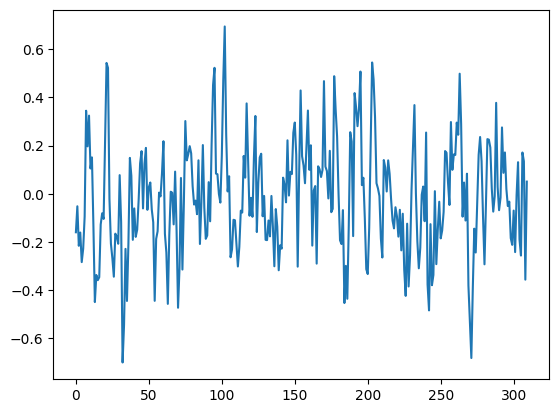

In [202]:
plt.plot(t)

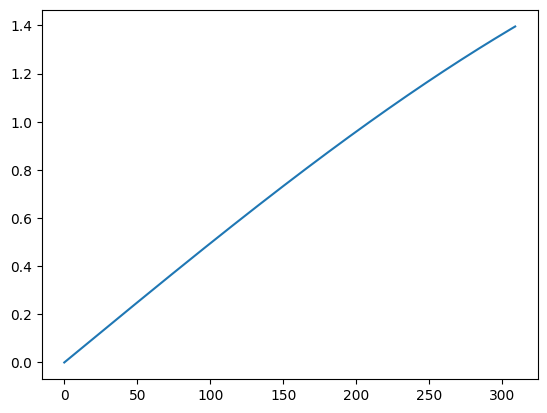

In [203]:
plt.plot(E_field)

In [17]:
vp = pot = nk.operator.PotentialEnergy(hi, Esin)

In [395]:
ha_t = lambda t: ha + vp

### Dynamics
integrator = nkx.dynamics.Heun(dt=0.05)
qgt = nk.optimizer.qgt.QGTJacobianDense(holomorphic=False)
te = nkx.TDVP(ha_t, vstate, integrator, qgt=qgt)
log = nk.logging.RuntimeLog()
obs = {"E": ha}
te.run(T=100.0, out=log, obs=obs)

 46%|████▋     | 46.5/100 [00:21<00:25, 2.13it/s, n=929, Generator=-0.501126 ± 0.000070 [σ²=0.000003, R̂=1.3523]]


KeyboardInterrupt: 

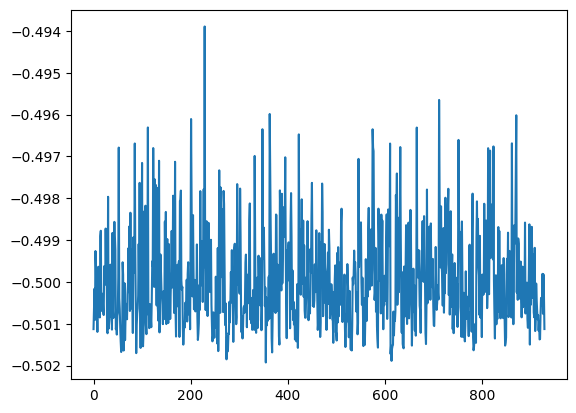

In [396]:
plt.plot(log['E']['Mean'])